In [ ]:
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import joblib

from utils import train_random_forest, train_stacker,train_xgboost, cap_outliers

In [6]:
prefecture_code = pd.read_csv("japan_housing_data/prefecture_code.csv")
prefecture_code.head()

,Code,JpName,EnName
0,1,北海道,Hokkaido
1,2,青森県,Aomori
2,3,岩手県,Iwate
3,4,宮城県,Miyagi
4,5,秋田県,Akita


In [7]:
df = pd.DataFrame()

data_dir = "japan_housing_data/trade_prices"

for f in os.listdir(data_dir):
    df_prefecture = pd.read_csv(os.path.join(data_dir, f), low_memory=False)
    df_prefecture["Code"] = int(f.split(".")[0])
    df = pd.concat([df, df_prefecture])

df.head()

,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks,Code
0,1,Residential Land(Land Only),Residential Area,40101,Fukuoka Prefecture,"Moji Ward,Kitakyushu City",Aobadai,Moji,30-60minutes,30.0,...,4.0,Category I Exclusively Low-story Residential Zone,50.0,80.0,4th quarter 2017,2017,4,NaN,NaN,40
1,2,Residential Land(Land Only),Residential Area,40101,Fukuoka Prefecture,"Moji Ward,Kitakyushu City",Oaza Ikawa,Komorie,30-60minutes,30.0,...,4.0,Urbanization Control Area,NaN,NaN,1st quarter 2018,2018,1,NaN,NaN,40
2,3,Residential Land(Land Only),Residential Area,40101,Fukuoka Prefecture,"Moji Ward,Kitakyushu City",Oaza Ikawa,Moji,1H-1H30,60.0,...,4.0,Urbanization Control Area,NaN,NaN,4th quarter 2017,2017,4,NaN,NaN,40
3,4,Residential Land(Land Only),Residential Area,40101,Fukuoka Prefecture,"Moji Ward,Kitakyushu City",Oaza Ikawa,Moji,1H-1H30,60.0,...,35.0,Urbanization Control Area,70.0,200.0,4th quarter 2016,2016,4,NaN,NaN,40
4,5,Residential Land(Land Only),Residential Area,40101,Fukuoka Prefecture,"Moji Ward,Kitakyushu City",Oaza Ikawa,Moji,1H-1H30,60.0,...,NaN,Urbanization Control Area,70.0,200.0,3rd quarter 2016,2016,3,NaN,NaN,40


In [8]:
df = pd.merge(left=df, right=prefecture_code, left_on="Code", right_on="Code", how="left")
df.head()

,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks,Code,JpName,EnName
0,1,Residential Land(Land Only),Residential Area,40101,Fukuoka Prefecture,"Moji Ward,Kitakyushu City",Aobadai,Moji,30-60minutes,30.0,...,50.0,80.0,4th quarter 2017,2017,4,NaN,NaN,40,福岡県,Fukuoka
1,2,Residential Land(Land Only),Residential Area,40101,Fukuoka Prefecture,"Moji Ward,Kitakyushu City",Oaza Ikawa,Komorie,30-60minutes,30.0,...,NaN,NaN,1st quarter 2018,2018,1,NaN,NaN,40,福岡県,Fukuoka
2,3,Residential Land(Land Only),Residential Area,40101,Fukuoka Prefecture,"Moji Ward,Kitakyushu City",Oaza Ikawa,Moji,1H-1H30,60.0,...,NaN,NaN,4th quarter 2017,2017,4,NaN,NaN,40,福岡県,Fukuoka
3,4,Residential Land(Land Only),Residential Area,40101,Fukuoka Prefecture,"Moji Ward,Kitakyushu City",Oaza Ikawa,Moji,1H-1H30,60.0,...,70.0,200.0,4th quarter 2016,2016,4,NaN,NaN,40,福岡県,Fukuoka
4,5,Residential Land(Land Only),Residential Area,40101,Fukuoka Prefecture,"Moji Ward,Kitakyushu City",Oaza Ikawa,Moji,1H-1H30,60.0,...,70.0,200.0,3rd quarter 2016,2016,3,NaN,NaN,40,福岡県,Fukuoka


In [9]:
df.columns

Index(['No', 'Type', 'Region', 'MunicipalityCode', 'Prefecture',
       'Municipality', 'DistrictName', 'NearestStation',
       'TimeToNearestStation', 'MinTimeToNearestStation',
       'MaxTimeToNearestStation', 'TradePrice', 'FloorPlan', 'Area',
       'AreaIsGreaterFlag', 'UnitPrice', 'PricePerTsubo', 'LandShape',
       'Frontage', 'FrontageIsGreaterFlag', 'TotalFloorArea',
       'TotalFloorAreaIsGreaterFlag', 'BuildingYear', 'PrewarBuilding',
       'Structure', 'Use', 'Purpose', 'Direction', 'Classification', 'Breadth',
       'CityPlanning', 'CoverageRatio', 'FloorAreaRatio', 'Period', 'Year',
       'Quarter', 'Renovation', 'Remarks', 'Code', 'JpName', 'EnName'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3906518 entries, 0 to 3906517
Data columns (total 41 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   No                           int64  
 1   Type                         object 
 2   Region                       object 
 3   MunicipalityCode             int64  
 4   Prefecture                   object 
 5   Municipality                 object 
 6   DistrictName                 object 
 7   NearestStation               object 
 8   TimeToNearestStation         object 
 9   MinTimeToNearestStation      float64
 10  MaxTimeToNearestStation      float64
 11  TradePrice                   int64  
 12  FloorPlan                    object 
 13  Area                         int64  
 14  AreaIsGreaterFlag            int64  
 15  UnitPrice                    float64
 16  PricePerTsubo                float64
 17  LandShape                    object 
 18  Frontage                     float64
 19  

In [11]:
df.describe().apply(lambda s: s.apply('{0:.1f}'.format))  

,No,MunicipalityCode,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,UnitPrice,PricePerTsubo,Frontage,TotalFloorArea,TotalFloorAreaIsGreaterFlag,BuildingYear,PrewarBuilding,Breadth,CoverageRatio,FloorAreaRatio,Year,Quarter,Code
count,3906518.0,3906518.0,3315977.0,3228071.0,3906518.0,3906518.0,3906518.0,1384415.0,1384415.0,2537063.0,1317660.0,3906518.0,1869804.0,3906518.0,2685837.0,3191877.0,3191877.0,3906518.0,3906518.0,3906518.0
mean,78354.1,20467.1,22.6,27.4,27605894.6,467.4,0.0,85148.9,281406.5,14.6,175.2,0.0,1995.5,0.0,6.8,61.0,209.0,2012.9,2.5,20.3
std,80173.6,12175.5,23.1,27.7,141745961.4,847.7,0.2,168683.2,557031.6,9.8,256.4,0.1,15.2,0.0,4.6,10.0,107.5,3.7,1.1,12.2
min,1.0,1101.0,0.0,0.0,100.0,10.0,0.0,1.0,2.0,0.1,10.0,0.0,1945.0,0.0,1.0,30.0,50.0,2005.0,1.0,1.0
25%,20780.0,12204.0,9.0,8.0,5000000.0,100.0,0.0,16000.0,55000.0,8.5,95.0,0.0,1984.0,0.0,4.0,60.0,200.0,2010.0,2.0,12.0
50%,48159.0,17210.0,16.0,15.0,14000000.0,185.0,0.0,40000.0,130000.0,12.0,105.0,0.0,1996.0,0.0,6.0,60.0,200.0,2013.0,3.0,17.0
75%,114733.0,28110.0,30.0,29.0,29000000.0,370.0,0.0,91000.0,300000.0,17.0,140.0,0.0,2009.0,0.0,7.0,60.0,200.0,2016.0,4.0,28.0
max,406575.0,47382.0,120.0,120.0,61000000000.0,5000.0,1.0,20000000.0,66000000.0,50.0,2000.0,1.0,2020.0,1.0,99.9,80.0,1300.0,2019.0,4.0,47.0


In [12]:
df['EnName'] = df['EnName'].apply(lambda x: x.rstrip())

In [13]:
missing_percentage = (df.isnull().mean() * 100).sort_values(ascending=False)
print("Missing percentage\n")
print(missing_percentage)

Missing percentage

Remarks                        94.064791
Renovation                     85.578052
FloorPlan                      84.713497
Purpose                        69.722960
TotalFloorArea                 66.270218
PricePerTsubo                  64.561407
UnitPrice                      64.561407
BuildingYear                   52.136301
Use                            51.709579
Structure                      51.041490
Frontage                       35.055643
Breadth                        31.247290
Classification                 30.514719
Direction                      28.901646
LandShape                      28.862788
Region                         28.595209
FloorAreaRatio                 18.293555
CoverageRatio                  18.293555
MaxTimeToNearestStation        17.367052
MinTimeToNearestStation        15.116812
TimeToNearestStation           15.116812
NearestStation                 14.483768
CityPlanning                   13.584118
DistrictName                    0.211

In [14]:
df['MunicipalityCode'] = df['MunicipalityCode'].astype(str)

In [15]:
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col].fillna('unkown', inplace=True)

In [16]:
df_copy = df.copy()

In [21]:
random_forest_dict = {}
xgboost_dict = {}
stacking_dict = {}

In [22]:
prefectures = df['EnName'].unique()
print(prefectures)

['Fukuoka' 'Saga' 'Kumamoto' 'Nagasaki' 'Kagoshima' 'Okinawa' 'Miyazaki'
 'Oita' 'Kagawa' 'Aichi' 'Shizuoka' 'Tokushima' 'Ibaraki' 'Nagano'
 'Hiroshima' 'Yamaguchi' 'Gifu' 'Tochigi' 'Shiga' 'Tottori' 'Yamanashi'
 'Fukui' 'Wakayama' 'Mie' 'Shimane' 'Kyoto' 'Osaka' 'Okayama' 'Toyama'
 'Aomori' 'Iwate' 'Ishikawa' 'Nara' 'Hokkaido' 'Niigata' 'Kanagawa'
 'Hyogo' 'Miyagi' 'Gunma' 'Ehime' 'Kochi' 'Saitama' 'Akita' 'Tokyo'
 'Fukushima' 'Yamagata' 'Chiba']


In [ ]:
os.makedirs("modelsKNN", exist_ok=True)

for prefecture in prefectures:
    print(f"Processing {prefecture}")
    prefecture_df = df[df['EnName'] == prefecture].copy()
    prefecture_df = prefecture_df.sort_values(by=['Year', 'Quarter'])
    
    split_index = int(len(prefecture_df) * 0.85)
    train_df = prefecture_df.iloc[:split_index]
    test_df = prefecture_df.iloc[split_index:]

    columns_to_cap = ["Area", "TotalFloorArea","FloorAreaRatio"]
    for col in columns_to_cap:    
        train_df[col] = cap_outliers(train_df[col])
    
    
    columns_to_drop = ['JpName', 'DistrictName', 'UnitPrice','PricePerTsubo', 'No', 
                   'TimeToNearestStation', 'TotalFloorAreaIsGreaterFlag', 'NearestStation', 
                   'Period', 'Year', 'Municipality', 'EnName', 'Prefecture', 
                   'AreaIsGreaterFlag', 'Quarter', 'FrontageIsGreaterFlag'
                   ]
    train_df = train_df.drop(columns= columns_to_drop)
    test_df = test_df.drop(columns= columns_to_drop)
    
    
    knn_imputer = KNNImputer(n_neighbors=3)

    numerical_columns = train_df.select_dtypes(include=['number']).columns
    train_df_knn = train_df.copy()
    test_df_knn = test_df.copy()

    train_df_knn[numerical_columns] = knn_imputer.fit_transform(train_df_knn[numerical_columns])
    test_df_knn[numerical_columns] = knn_imputer.transform(test_df_knn[numerical_columns])
    joblib.dump(knn_imputer, f"imputer_models/{prefecture}.pkl")

    X_train = train_df_knn.drop(columns=["TradePrice"])
    y_train = train_df_knn["TradePrice"]
    X_test = test_df_knn.drop(columns=["TradePrice"])
    y_test = test_df_knn["TradePrice"]
    
        
    rf_result = train_random_forest(X_train.copy(), y_train, X_test.copy(), y_test)
    random_forest_dict[prefecture] = rf_result
    joblib.dump(rf_result['model'], f"modelsKNN/random_forest_{prefecture}.pkl")
    
    xgb_result = train_xgboost(X_train.copy(), y_train, X_test.copy(), y_test)
    xgboost_dict[prefecture] = xgb_result
    joblib.dump(xgb_result['model'], f"modelsKNN/xgboost_{prefecture}.pkl")
    
    stacker_result = train_stacker(X_train.copy(), y_train, X_test.copy(), y_test, rf_result['top_12_features'])
    stacking_dict[prefecture] = stacker_result
    joblib.dump(stacker_result['model'], f"modelsKNN/stacking_{prefecture}.pkl")

    best_model = sorted([('random_forest', rf_result), ('xgboost', xgb_result),('stacking', stacker_result)], key=lambda x: x[1]['r2'])[-1]
    joblib.dump(best_model[1]['model'], f"best_models/{best_model[0]}_{prefecture}.pkl")
    print(f"Completed {prefecture}")

Processing Fukuoka
Random Forest R-squared: 0.5510
XGB Regressor R-squared: 0.4651
Stacking Regressor R-squared: 0.4600
Completed Fukuoka
Processing Saga
Random Forest R-squared: -0.1367
XGB Regressor R-squared: -1.0961
Stacking Regressor R-squared: -0.4401
Completed Saga
Processing Kumamoto
Random Forest R-squared: 0.2137
XGB Regressor R-squared: 0.6235
Stacking Regressor R-squared: 0.5975
Completed Kumamoto
Processing Nagasaki
Random Forest R-squared: 0.6145
XGB Regressor R-squared: 0.6609
Stacking Regressor R-squared: 0.6198
Completed Nagasaki
Processing Kagoshima
Random Forest R-squared: 0.5221
XGB Regressor R-squared: 0.6150
Stacking Regressor R-squared: 0.4857
Completed Kagoshima
Processing Okinawa
Random Forest R-squared: 0.6405
XGB Regressor R-squared: 0.6747
Stacking Regressor R-squared: 0.6523
Completed Okinawa
Processing Miyazaki
Random Forest R-squared: 0.4137
XGB Regressor R-squared: 0.3936
Stacking Regressor R-squared: 0.4051
Completed Miyazaki
Processing Oita
Random Fore

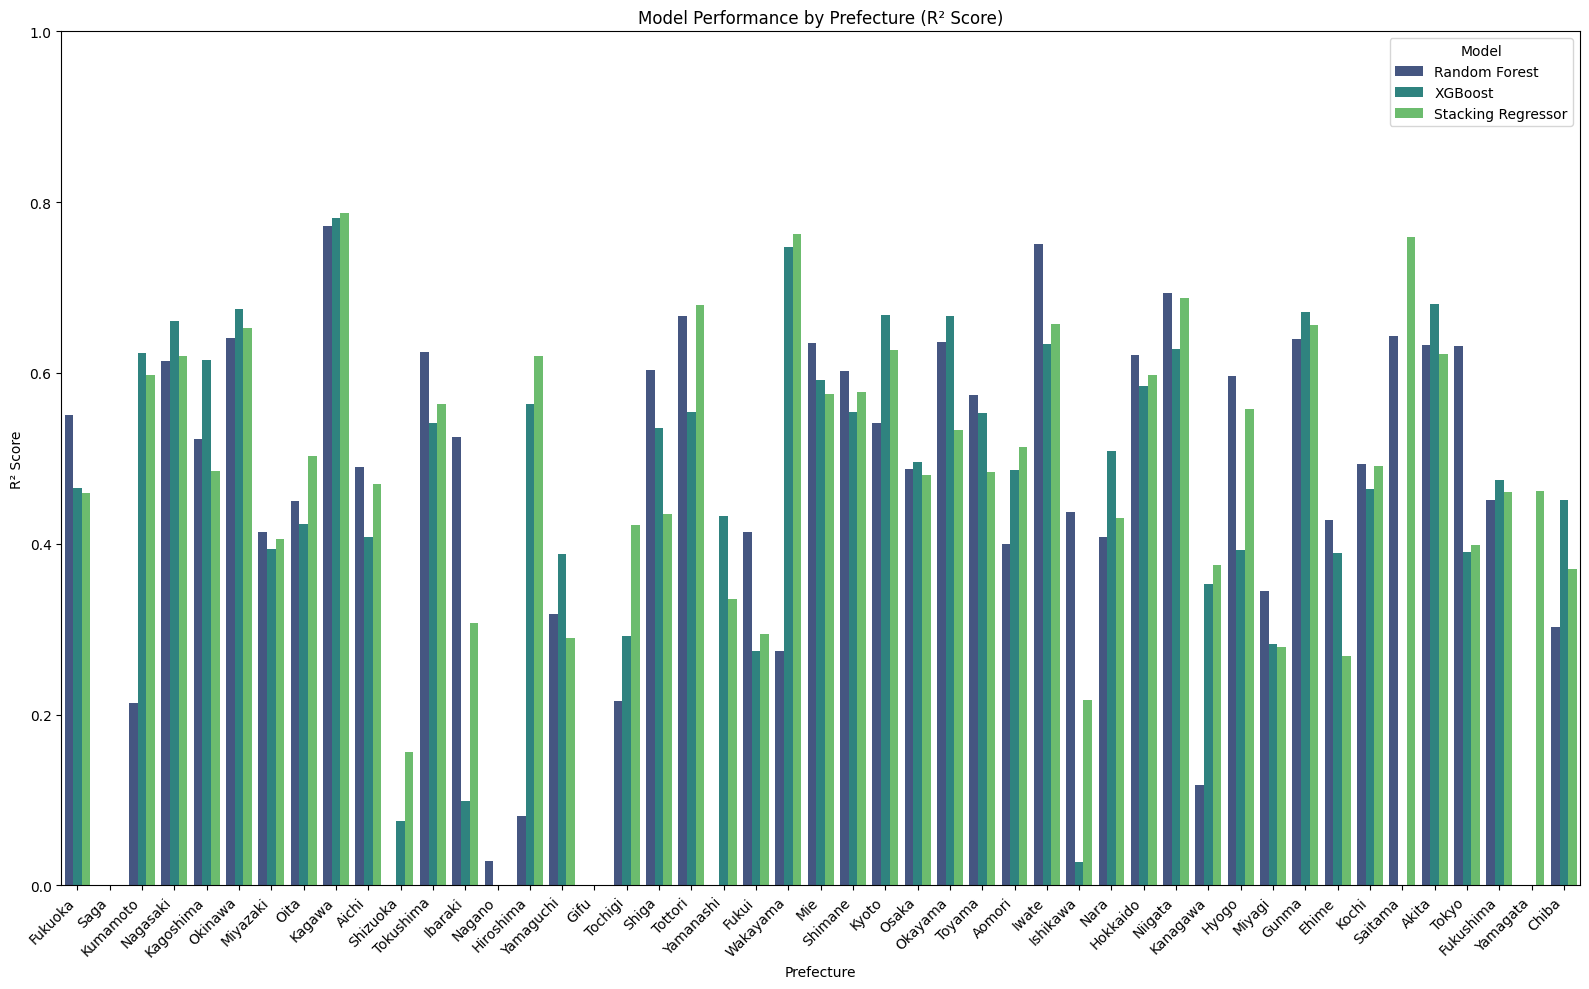

In [ ]:
from utils import plot_scores

plot_scores(random_forest_dict, xgboost_dict, stacking_dict)